In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numba as nb
from tqdm import tqdm

In [2]:
spec = [
    ('S', nb.int32[:, :]),
    ('L', nb.int32),
    ('epsilon', nb.float32),
    ('alpha', nb.float32),
    ('Q', nb.float32[:, :, :, :]),
]

@nb.experimental.jitclass(spec)
class Simulation():
    def __init__(self, L, S, epsilon, Q, alpha=0.05):
        self.L = L
        self.epsilon = epsilon
        self.S = S
        self.alpha = alpha
        self.Q = Q

    def update(self, time):
        for _ in range(time):
            for x in range(self.L):
                for y in range(self.L):
                    # 判断属于大多数or少数
                    near = self.S[(x+1)%self.L, y]+self.S[(x-1)%self.L, y]+self.S[x, (y+1)%self.L]+self.S[x, (y-1)%self.L] #将0也划分为大多数
                    if near == 0 : stat = 1
                    else : stat = int((np.sign(self.S[x, y]*near)+1)/2)

                    # 选择是否翻转
                    if np.random.random() < self.epsilon :
                        action = np.random.choice(2)
                        if action == 1 : self.S[x, y] = -1 * self.S[x, y]
                    else:
                        if self.Q[x, y, stat, 1] < self.Q[x, y, stat, 0]:
                            self.S[x, y] = -1 * self.S[x, y]
                            action = 1
                        else: action = 0

                    # 更新
                    if int((np.sign(self.S[x, y]*near)+1)/2) == 1 or near == 0 : c = 0
                    else: c = 1

                    self.Q[x, y, stat, action] = self.Q[x, y, stat, action] + self.alpha*(c-self.Q[x, y, stat, action])



L = 32
S = np.ones((L, L), dtype=np.int32)
for i in range(L):
    for j in range(L):
        if np.random.choice((0, 1)):
            S[i, j] *= -1
Q = np.zeros((L, L, 2, 2), dtype=np.float32)
epsilon = 0.2
alpha = 0.05

Ising = Simulation(L, S, epsilon, Q, alpha)

15it [01:18,  5.24s/it]


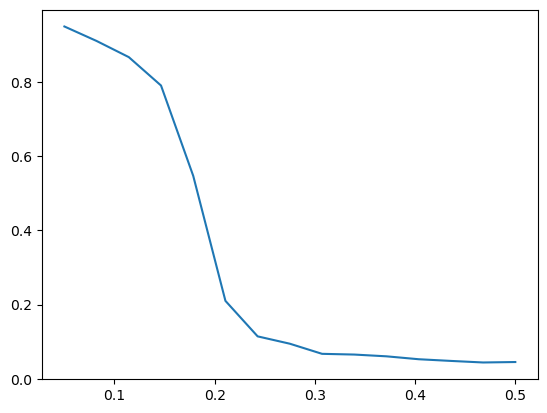

In [3]:
n_epsilon = 15
n_init = 10000
n_sum = 200
n_realize = 1000

epsilon_list = np.linspace(0.50, 0.05, n_epsilon)
M_list = np.zeros(n_epsilon)
for num, epsilon in tqdm(enumerate(epsilon_list)):
    
    Q = np.zeros((L, L, 2, 2), dtype=np.float32)
    Ising.Q = Q
    Ising.epsilon = epsilon

    Ising.update(n_init)
    for _ in range(n_sum):
        M_list[num] += np.abs(np.sum(Ising.S)/L**2)
        Ising.update(n_realize)

    M_list[num] = M_list[num]/n_sum


plt.plot(epsilon_list, M_list)
plt.show()